# Fluorescence Lifetime Simulation

This notebook illustrates how we simulate fluorescence lifetime imaging and create datasets for the training of recurrent neural networks.

Different from existing deep learning-based methods, we generate the data on the timestamp level, which means the data points are not histograms but timestamps. We assume that the timestamps from one pixel is indenpendent from the others, so the dataset contains data points on the pixel level instead of the image level.

The mathematical expression os the simulation is explained in our paper titled *Coupling a Recurrent Neural Network to SPAD TCSPC Systems for Real-time Fluorescence Lifetime Imaging*.



In [1]:
import os

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

Each dataset contains the `data` and the `label`. `data` is a matrix with a shape of `[num_sample, num_timestamps]`, each row of which contains the timestamps given the lifetime(s). `label` is a matrix with a shape of `[num_sample, N - 1]`, each row of which contains the lifetime(s) to predict.

In [2]:
# size of the dataset
num_timestamps = 1024
num_sample = 500000

# parameters of the IRF
FWHM = 0.1673   # ns
irf_shift = 1.968   # ns

# parameters of the TDC and laser
period = 50     # ns
LSB = 0.05      # ns
n_bit = 12

normalization_coeff = LSB

In [3]:
# mono-exponential model
# parameters of fluorescence and background noise

N = 2

p_values = [0.9, 0.1]           # normalized intensities of fluorescence and background noise
assert np.sum(p_values) == 1
assert len(p_values) == N

tau_limits = np.array([
    [0.2, 5],                   # range of the lifetime
])
assert tau_limits.shape[0] == N - 1
assert tau_limits.shape[1] == 2

In [4]:
# # bi-exponential model

# N = 3

# p_values = [0.45, 0.45, 0.1]
# assert np.sum(p_values) == 1
# assert len(p_values) == N

# tau_limits = np.array([
#     [0.2, 1],   # small lifetime
#     [2, 3]      # large lifetime
# ])
# assert tau_limits.shape[0] == N - 1
# assert tau_limits.shape[1] == 2

Text(0, 0.5, 'Counts')

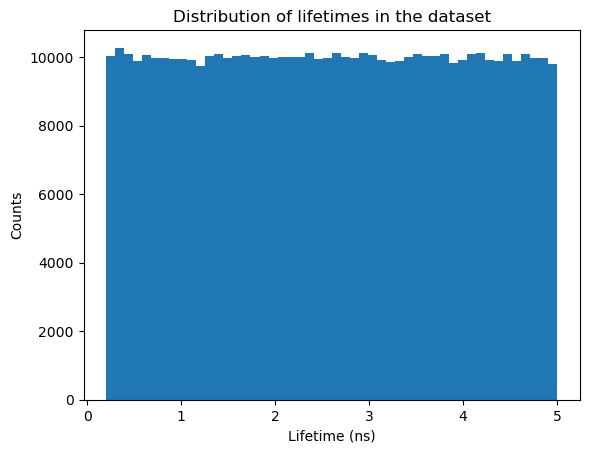

In [5]:
# generate the lifetimes

taus = np.zeros([num_sample, N - 1])

for i in range(N - 1):
    taus_i = np.random.uniform(tau_limits[i][0], tau_limits[i][1], size=(num_sample))
    taus[:, i] = taus_i

plt.hist(taus, bins=50, histtype='stepfilled', alpha=1/(N-1))
plt.title('Distribution of lifetimes in the dataset')
plt.xlabel('Lifetime (ns)')
plt.ylabel('Counts')

In [6]:
data = np.zeros((num_sample, num_timestamps), dtype=np.float32)


for idx, tau in tqdm(enumerate(taus)):

    num_components = np.random.multinomial(num_timestamps, p_values)

    timestamps_raw = np.random.exponential(scale=tau, size=(num_timestamps * 5, N - 1))

    irf = np.random.normal(
        loc=irf_shift,
        scale=FWHM/(2*np.sqrt(2*np.log(2))),
        size=(num_timestamps * 5, N - 1)
    )

    timestamps = timestamps_raw + irf

    entry = []

    for i in range(N - 1):
        f_timestamps = timestamps[:, i]
        f_timestamps = f_timestamps[(f_timestamps < period) * (f_timestamps >= 0)]

        entry.append(f_timestamps[0:num_components[i]])

    bg_noise = np.random.uniform(0, period, size=[num_components[-1]])

    entry.append(bg_noise)

    entry = np.concatenate(entry, axis=0)

    np.random.shuffle(entry)

    data[idx] = entry

data = (data / normalization_coeff).astype(int) 
    

500000it [01:02, 8042.76it/s]


<Axes: ylabel='Count'>

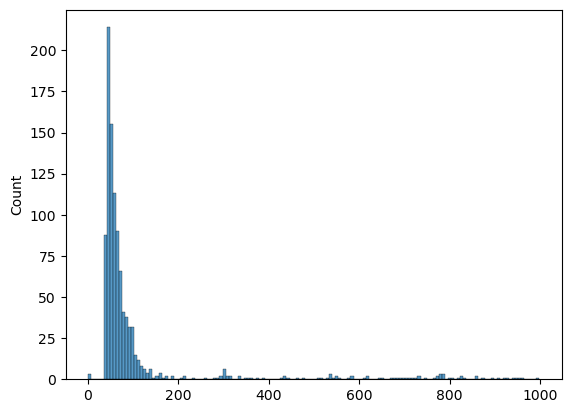

In [7]:
sns.histplot(data[0])

In [8]:
save_path = 'dataset'

if not os.path.exists(save_path):
    os.mkdir(save_path)
    print('Created folder:', save_path)
else:
    print(save_path, 'already exists.')

np.save(os.path.join(save_path, 'data.npy'), data)
np.save(os.path.join(save_path, 'label.npy'), taus)

Created folder: dataset
